# Lab | Comparing regression models

For this lab, we will be using the same dataset for the customer analysis case study we used in the previous labs. We recommend using the same notebook since you will be reusing the same variables you previous created and used in labs.

Instructions
1. Fit the models LinearRegression,Lasso and Ridge and compare the model performances. [Done]
2. Define a function that takes a list of models and trains (and tests) them so we can try a lot of them without repeating code.
3. Use feature selection techniques (P-Value, RFE) to select a subset of features to train the model with (if necessary).
4. (optional) Re-fit the models with the selected features.

In [58]:
#Importing libraries and data
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold # It only works with numerical features
from sklearn.linear_model import Lasso,Ridge,ElasticNet, LinearRegression, LassoCV, RidgeCV
from sklearn.feature_selection import RFE  ## recursive feature elemination technique
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('data/marketing_customer_analysis_clean (2).csv')
numericals_df = df.select_dtypes(include=np.number).drop(columns = 'unnamed:_0')
numericals_df


,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,month
0,4809.216960,48029,61,7.000000,52,0.000000,9,292.800000,2
1,2228.525238,0,64,3.000000,26,0.000000,1,744.924331,1
2,14947.917300,22139,100,34.000000,31,0.000000,2,480.000000,2
3,22332.439460,49078,97,10.000000,3,0.000000,2,484.013411,1
4,9025.067525,23675,117,15.149071,31,0.384256,7,707.925645,1
...,...,...,...,...,...,...,...,...,...
10905,15563.369440,0,253,15.149071,40,0.384256,7,1214.400000,1
10906,5259.444853,61146,65,7.000000,68,0.000000,6,273.018929,1
10907,23893.304100,39837,201,11.000000,63,0.000000,2,381.306996,2
10908,11971.977650,64195,158,0.000000,27,4.000000,6,618.288849,2


In [79]:
#define X and Y
X = numericals_df.drop(columns = "total_claim_amount")

y = numericals_df[["total_claim_amount"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


X_train_reduced = X_train[['income', 'monthly_premium_auto']]
X_test_reduced = X_test[['income', 'monthly_premium_auto']]


## Variance threshold method

In [80]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

#display(X_train)
print("Initial number of numerical columns: ",X_train.shape)
print()

selector = VarianceThreshold() # Default threshold value is 0
# Features with a training-set variance lower than this threshold will be removed.
selector.fit(X_train)

kept_features_indexes = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features_indexes
kept_features = list(X_train.iloc[:,kept_features_indexes].columns)
kept_features

X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

X_train = pd.DataFrame(X_train, columns=kept_features)
X_test  = pd.DataFrame(X_test, columns=kept_features)

X_train
print("Final number of numerical columns: ",X_train.shape)
print()
X_train


Initial number of numerical columns:  (8728, 8)

Final number of numerical columns:  (8728, 8)



,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,month
0,4665.129599,0.0,62.0,26.0,62.0,0.0,3.0,2.0
1,10288.924950,96337.0,127.0,19.0,12.0,0.0,3.0,1.0
2,4873.436612,18866.0,126.0,4.0,62.0,0.0,1.0,1.0
3,6944.739992,0.0,68.0,24.0,31.0,0.0,2.0,1.0
4,2472.469209,63860.0,62.0,26.0,81.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
8723,3810.238281,0.0,108.0,7.0,57.0,0.0,1.0,2.0
8724,3815.851163,38651.0,98.0,12.0,83.0,0.0,1.0,1.0
8725,7850.590399,0.0,69.0,5.0,78.0,0.0,2.0,2.0
8726,4974.235309,0.0,70.0,18.0,74.0,0.0,3.0,2.0


## Correlation matrix

['monthly_premium_auto', 'income', 'total_claim_amount']


,monthly_premium_auto,income,total_claim_amount
0,61,48029,292.800000
1,64,0,744.924331
2,100,22139,480.000000
3,97,49078,484.013411
4,117,23675,707.925645
...,...,...,...
10905,253,0,1214.400000
10906,65,61146,273.018929
10907,201,39837,381.306996
10908,158,64195,618.288849


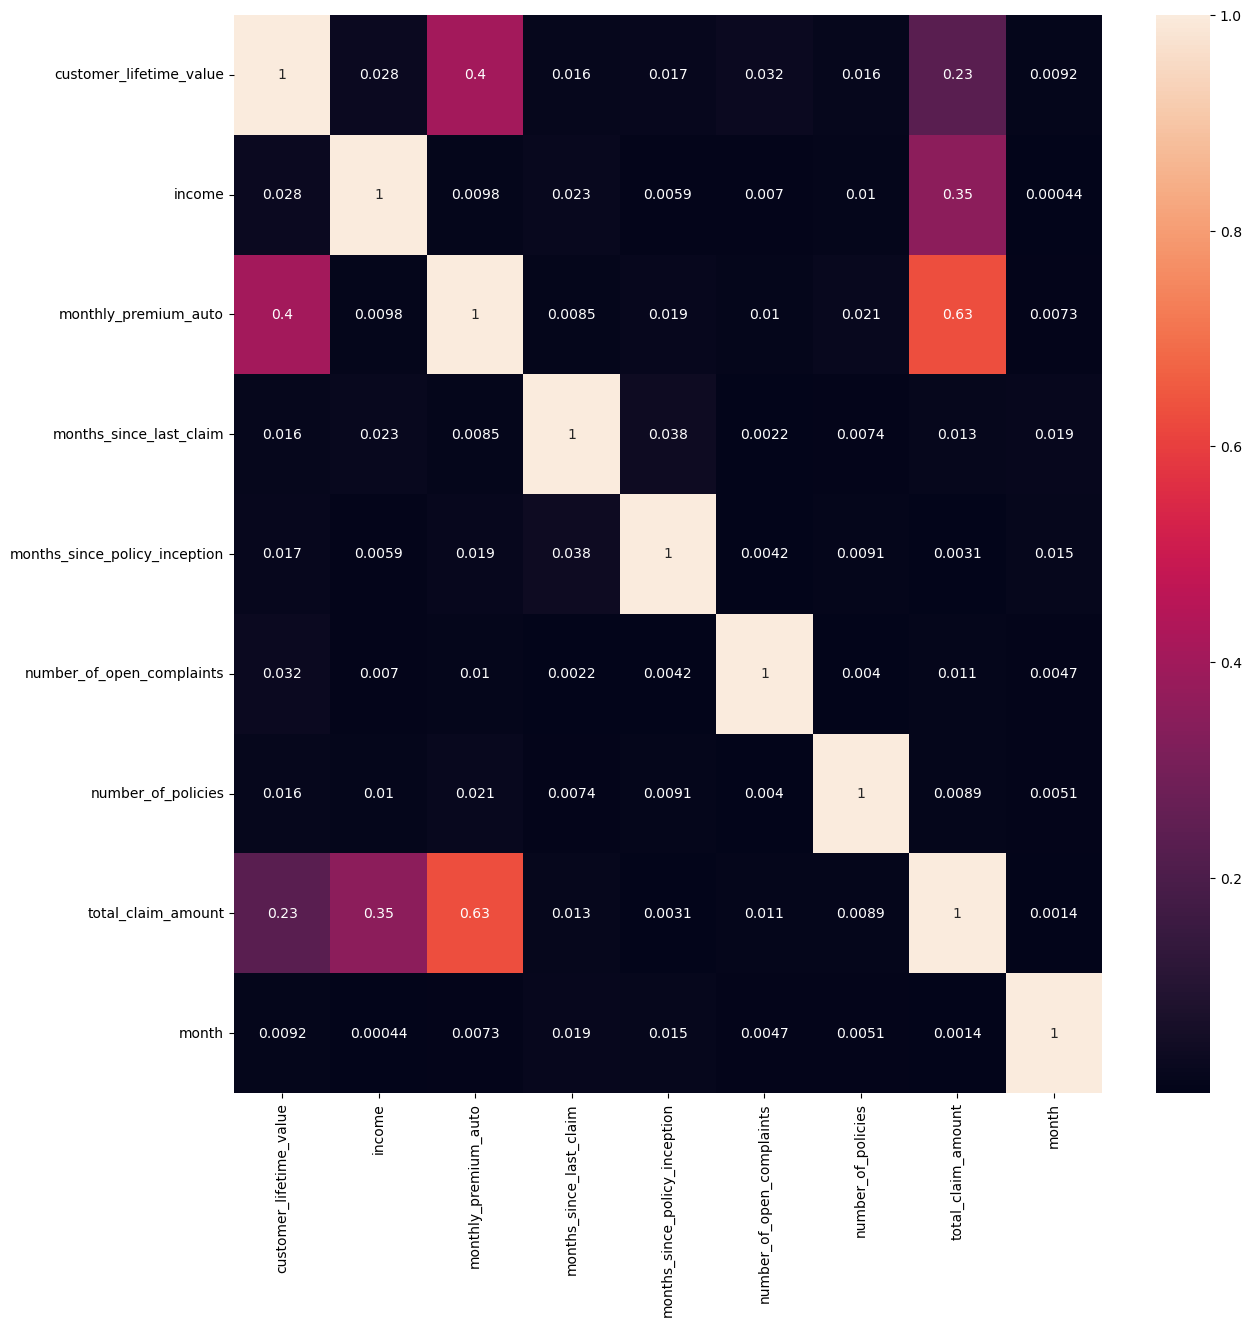

In [81]:
c = abs(numericals_df.corr())

fig, ax = plt.subplots(figsize=(14,14))

sns.heatmap(c, annot=True);


c_last = c["total_claim_amount"].sort_values(ascending=False)

#c_last
c_thr = .3
cols_to_keep = list(c_last[c_last > c_thr].index)[1:] + [list(c_last[c_last > c_thr].index)[0]]
print(cols_to_keep)
numericals_df[cols_to_keep]

In [82]:
numericals_df

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,month
0,4809.216960,48029,61,7.000000,52,0.000000,9,292.800000,2
1,2228.525238,0,64,3.000000,26,0.000000,1,744.924331,1
2,14947.917300,22139,100,34.000000,31,0.000000,2,480.000000,2
3,22332.439460,49078,97,10.000000,3,0.000000,2,484.013411,1
4,9025.067525,23675,117,15.149071,31,0.384256,7,707.925645,1
...,...,...,...,...,...,...,...,...,...
10905,15563.369440,0,253,15.149071,40,0.384256,7,1214.400000,1
10906,5259.444853,61146,65,7.000000,68,0.000000,6,273.018929,1
10907,23893.304100,39837,201,11.000000,63,0.000000,2,381.306996,2
10908,11971.977650,64195,158,0.000000,27,4.000000,6,618.288849,2


## Models

### OLS

In [83]:
lm = LinearRegression()
model = lm.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

LinearRegression: Train -> 0.5236010813915328, Test -> 0.5069409388151644


### Lasso

In [84]:
model=Lasso(alpha=0)

model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

Lasso: Train -> 0.5236010813915328, Test -> 0.5069409388151643


### Ridge

In [85]:
model=Ridge(alpha=0)
model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

Ridge: Train -> 0.5236010813915328, Test -> 0.5069409388151642


### EleasticNet

In [86]:
model=ElasticNet(alpha=0)
model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

ElasticNet: Train -> 0.5236010813915328, Test -> 0.5069409388151643


### Lasso CV

In [87]:
model = LassoCV(alphas = ,cv=10, max_iter=10000, n_jobs=-1)
model.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")
optimal_alpha = model.alpha_
print(f"The optimal alpha is: {optimal_alpha}")

LassoCV: Train -> 0.5235350030704338, Test -> 0.5074975003887321
The optimal alpha is: 27


### Ridge CV

In [102]:
alphas = range(0, 5000, 50)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)
print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")
optimal_alpha = ridge_cv.alpha_
print(f"The optimal alpha is: {optimal_alpha}")

LassoCV: Train -> 0.5235350030704338, Test -> 0.5074975003887321
The optimal alpha is: 4950


## Recursive feature elimination (RFE)
Use feature selection techniques (P-Value, RFE) to select a subset of features to train the model with (if necessary).

In [88]:
X_train_rfe, X_test_rfe, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train_rfe = X_train_rfe.select_dtypes(include=np.number)
X_test_rfe = X_test_rfe.select_dtypes(include=np.number)

X_train = pd.DataFrame(X_train_rfe, columns=X.columns)
X_test  = pd.DataFrame(X_test_rfe, columns=X.columns)

selector = RFE(lm, n_features_to_select= 2, step = 1, verbose = 1) # Step is how many features to add or drop everytime
selector.fit(X_train_rfe, y_train)

kept_features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train_rfe.iloc[:,kept_features].columns)

X_train_rfe = selector.transform(X_train_rfe)
X_test_rfe  = selector.transform(X_test_rfe)

X_train_rfe = pd.DataFrame(X_train_rfe, columns=kept_features)
X_test_rfe  = pd.DataFrame(X_test_rfe, columns=kept_features)

print("Final selected features: ")
display(X_train_rfe)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Final selected features: 


,monthly_premium_auto,month
0,62.0,2.0
1,127.0,1.0
2,126.0,1.0
3,68.0,1.0
4,62.0,1.0
...,...,...
8723,108.0,2.0
8724,98.0,1.0
8725,69.0,2.0
8726,70.0,2.0


### P values

In [89]:
def feature_selection_pvalue(X, y, significance_level=0.05):
    # Add a constant term (intercept) to the feature matrix X
    X = sm.add_constant(X)
    # Fit a linear regression model using Ordinary Least Squares
    model = sm.OLS(y, X).fit()
    # Extract p-values for each coefficient, excluding the constant term
    p_values = model.pvalues[1:]  # Exclude the constant term
     # Select features whose p-values are less than the specified significance level
    selected_features = X.columns[1:][p_values < significance_level]
    # Return the list of selected features
    return selected_features
# Use case:
selected_features_pvalue = feature_selection_pvalue(X, y)
# Print or display the selected features
print("Selected Features based on P-value:")
print(selected_features_pvalue)

Selected Features based on P-value:
Index(['income', 'monthly_premium_auto'], dtype='object')


## Multiple model evaluation function

In [90]:
#Define a function that takes a list of models and trains (and tests) them so we can try a lot of them without repeating code.

In [92]:
# List of models to train and evaluate
model_list = [LinearRegression(),Ridge(alpha=1.0),Lasso(alpha=0.1),ElasticNet(alpha=0),
              RFE(lm, n_features_to_select= 2, step = 1),
              RFE(lm, n_features_to_select= 3, step = 1),
              RFE(lm, n_features_to_select= 4, step = 1),
              RFE(lm, n_features_to_select= 5, step = 1),
              RFE(lm, n_features_to_select= 6, step = 1),
              RFE(lm, n_features_to_select= 7, step = 1),
              RFE(lm, n_features_to_select= 8, step = 1),
              ]
    
def multi_model_evaluation(model_list,X_train,y_train,X_test,y_test):
    for model in model_list:
        model.fit(X_train, y_train)
        print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")

In [94]:
multi_model_evaluation(model_list,X_train_reduced,y_train,X_test_reduced,y_test)

LinearRegression: Train -> 0.5236010813915328, Test -> 0.5069409388151644
Ridge: Train -> 0.5236010813901146, Test -> 0.5069409458319787
Lasso: Train -> 0.5236004372408718, Test -> 0.5069451375143181
ElasticNet: Train -> 0.5236010813915328, Test -> 0.5069409388151643
RFE: Train -> 0.40507509006256937, Test -> 0.37379339045947346
RFE: Train -> 0.4050976112034831, Test -> 0.37381070129657135
RFE: Train -> 0.4051289610697927, Test -> 0.37375072880195725
RFE: Train -> 0.4052558255440548, Test -> 0.3733972130001596
RFE: Train -> 0.4053850037146587, Test -> 0.3731796976517495
RFE: Train -> 0.5233825631778544, Test -> 0.507199465123262
RFE: Train -> 0.5236010813915328, Test -> 0.5069409388151644
